In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/vt_ev_registrations_public.csv')

In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2003-06-03,20.0
2003-06-04,22.0
2003-06-05,2.0
2005-06-02,2.0
2006-10-16,2.0
...,...
2019-03-14,2.0
2019-03-19,1.0
2019-03-21,1.0


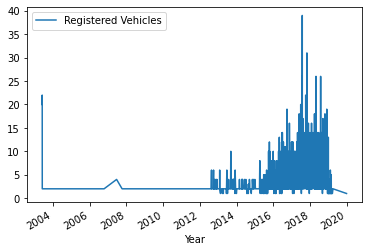

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

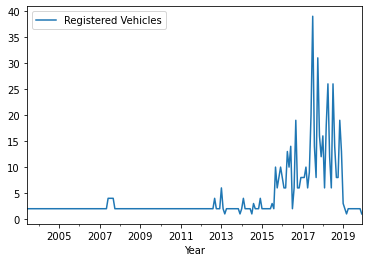

In [7]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(-1.8442437449728664,
 0.35872749545890725,
 12,
 186,
 {'1%': -3.466005071659723,
  '5%': -2.8772078537639385,
  '10%': -2.5751221620996647},
 972.9093423917138)

## Modeling

In [16]:
# Splitting Training and Testing data; using after 2019 as test

train = df[:'2018-12']
test = df['2019':]
combined = df

test

,Registered Vehicles
Year,
2019-01-31,3.0
2019-02-28,2.0
2019-03-31,1.0
2019-04-30,2.0
2019-05-31,2.0
2019-06-30,2.0
2019-07-31,2.0
2019-08-31,2.0
2019-09-30,2.0


In [17]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1257.761, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1087.310, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1137.782, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1078.260, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=997.579, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=994.185, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=988.533, Time=0.10 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=990.530, Time=0.11 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=990.532, Time=0.12 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=990.758, Time=0.12 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=992.162, Time=0.19 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=988.386, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=993.467, Time=0.10 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=990.360, Time=0.17 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=9

### The best model is :  ARIMA (5, 0, 0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3152      0.056      5.614      0.000       0.205       0.425
ar.L2         -0.2045      0.066     -3.098      0.002      -0.334      -0.075
ar.L3          0.5604      0.044     12.634      0.000       0.473       0.647
ar.L4          0.1054      0.042      2.520      0.012       0.023       0.187
ar.L5          0.2108      0.066      3.184      0.001       0.081       0.340
sigma2        10.9503      0.504     21.726      0.000       9.962      11.938


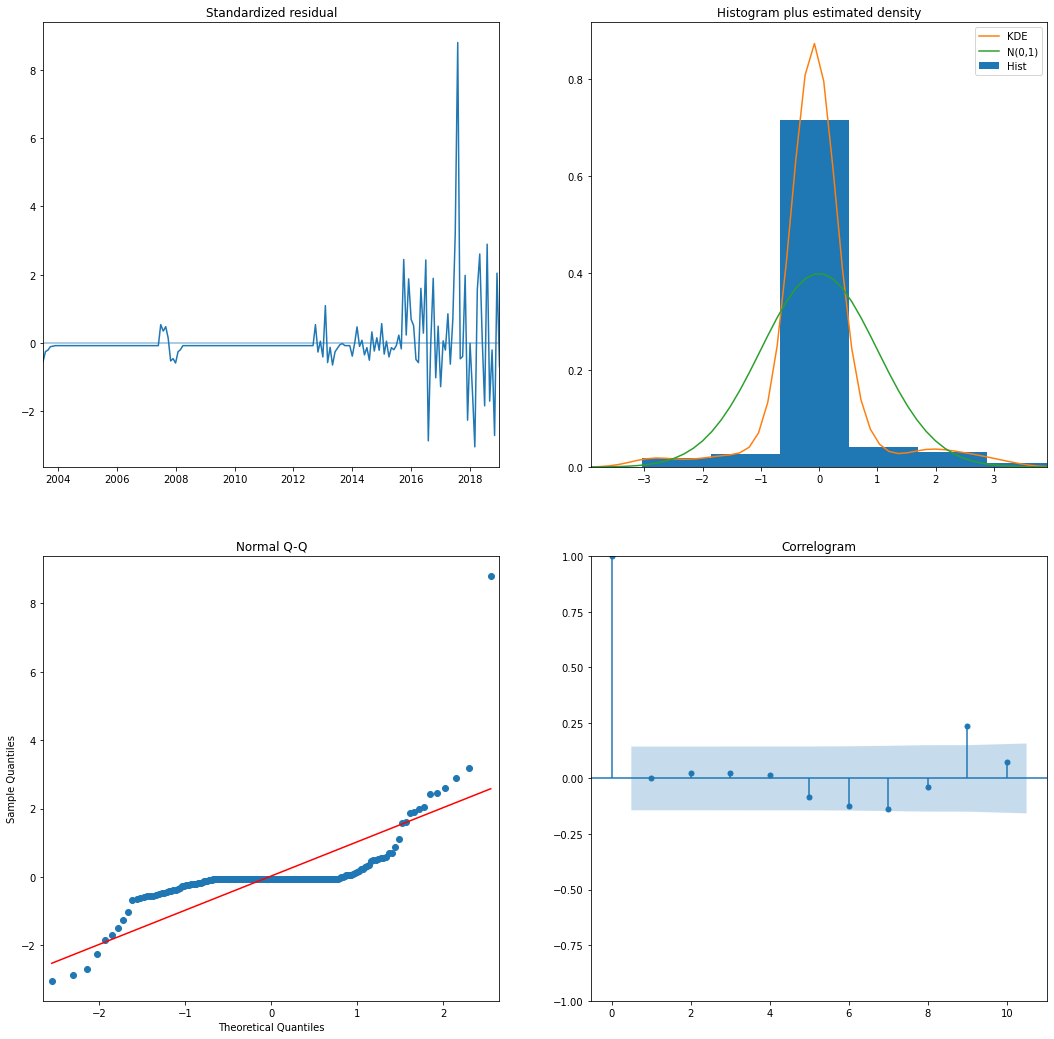

In [18]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(5,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [19]:
pred = output.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2019-01-31,2.002645,14.974149
2019-02-28,6.393367,19.993909
2019-03-31,6.562030,20.230859
2019-04-30,4.191068,19.120032
2019-05-31,3.948698,19.975521
2019-06-30,3.920070,20.227037
2019-07-31,3.707131,20.459725
2019-08-31,3.458485,20.731087
2019-09-30,2.947105,20.701286
2019-10-31,2.704252,20.932709


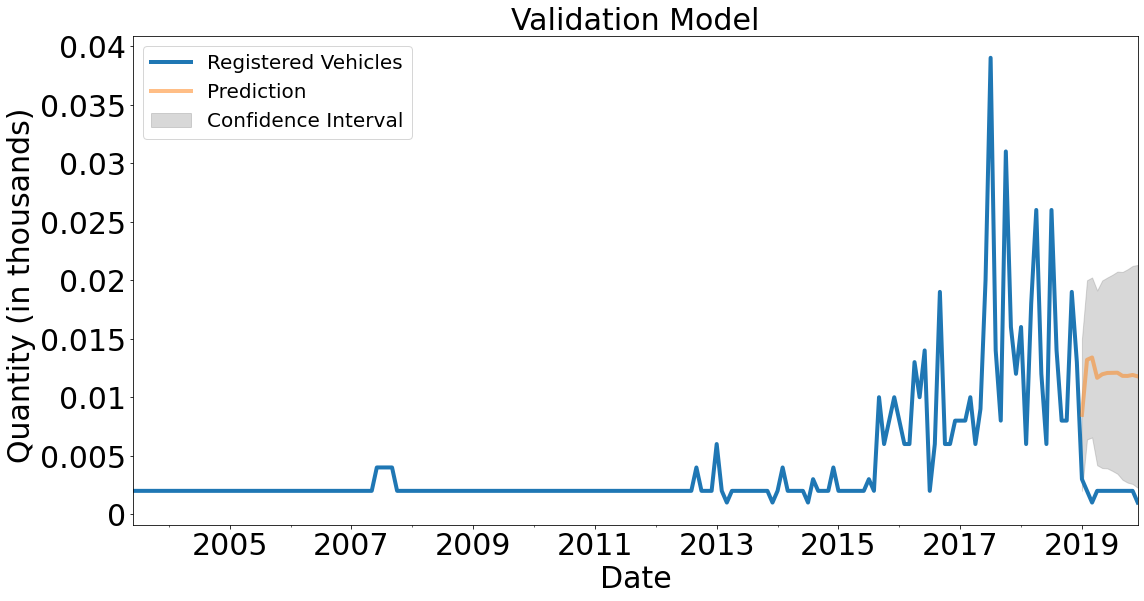

In [20]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()